In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score


In [58]:
# Load your dataset
data = pd.read_csv('github_data/merged_data_for_analysis.csv')

# Drop the unique identifier columns
data_Nan = data.drop(['CBG_ID','TRACT_ID','TRACTCE', 'COUNTYFP', 'BLKGRPCE'], axis=1)

data_cleaned = data_Nan.dropna()

### Correlation Matrix with SocioEconomic and Infrastructure Vars

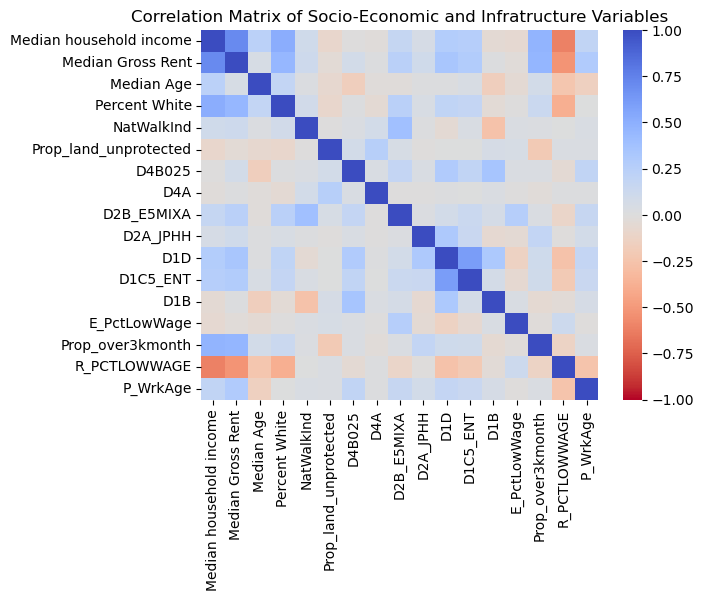

In [59]:
correlation_matrix = data_Nan.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm_r', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Socio-Economic and Infratructure Variables")
plt.show()

### First Clustering: 3-dim PCA then GMM with 5 clusters

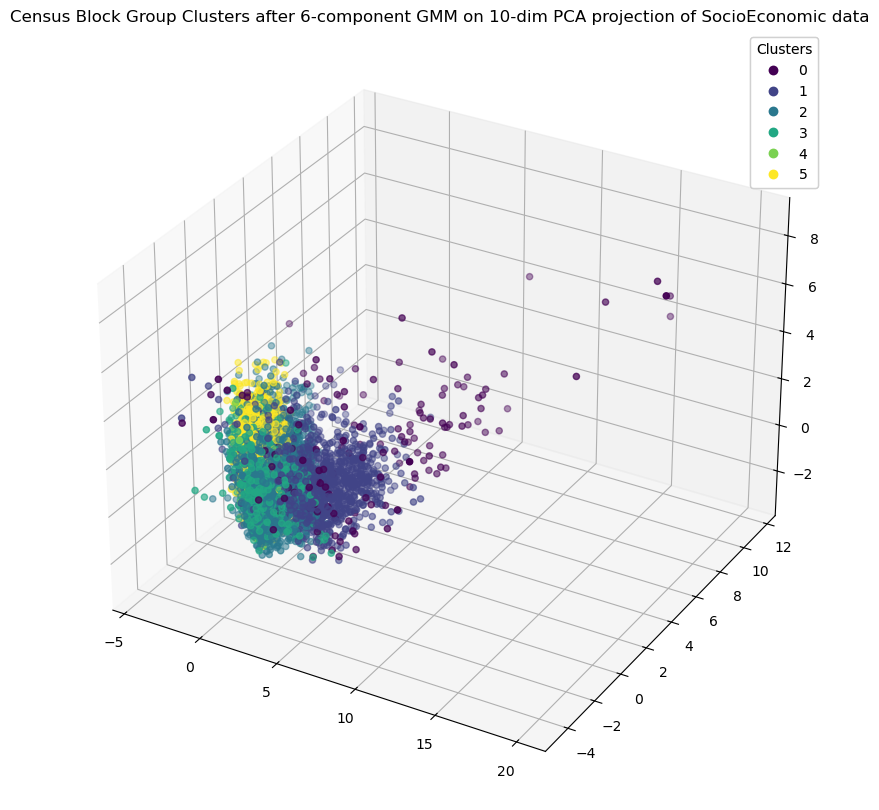

In [60]:
PCA_COMPONENTS = 10
GMM_COMPONENTS = 6

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_cleaned)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=PCA_COMPONENTS)
data_pca = pca.fit_transform(data_normalized)

# Fit a Gaussian Mixture Model
# Choose the number of components based on your data and domain knowledge
gmm = GaussianMixture(n_components=GMM_COMPONENTS, covariance_type='full', random_state=42)
gmm.fit(data_pca)

# Predict the clusters
labels_best = gmm.predict(data_pca)

# Plot the results
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=labels_best, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.title(F'Census Block Group Clusters after {GMM_COMPONENTS}-component GMM on {PCA_COMPONENTS}-dim PCA projection of SocioEconomic data')
plt.show()

# Optionally, examine the PCA and GMM performance further, or adjust the number of GMM components


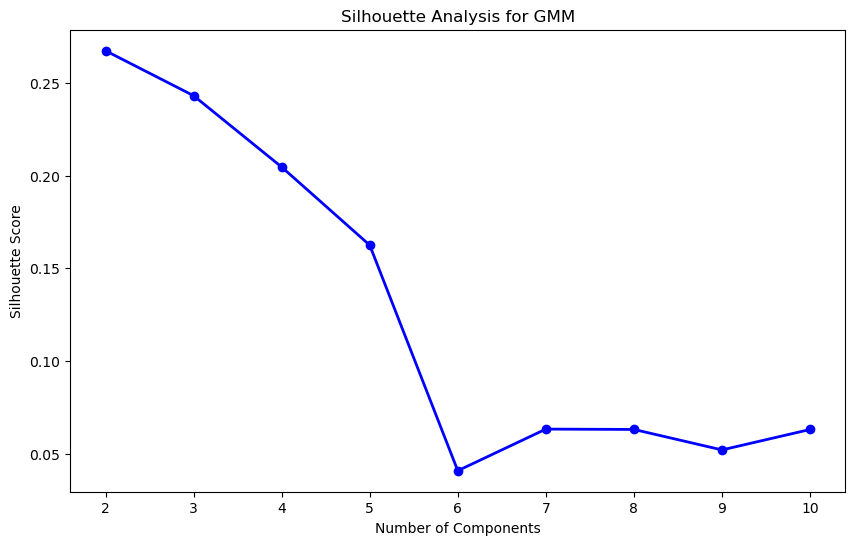

In [61]:
silhouette_scores = []
max_components = 10
for n in range(2, max_components + 1):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(data_pca)
    labels_i = gmm.predict(data_pca)
    score = silhouette_score(data_pca, labels_i)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_components + 1), silhouette_scores, 'bo-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for GMM')
plt.show()

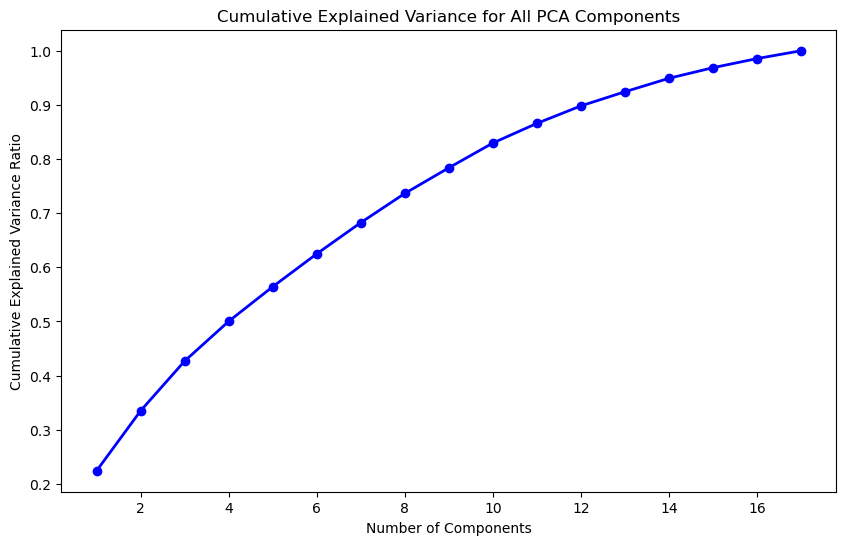

In [62]:
pca_all = PCA()
data_pca_all = pca_all.fit_transform(data_normalized)
cumulative_variance_ratio_all = np.cumsum(pca_all.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, data_normalized.shape[1] + 1), cumulative_variance_ratio_all, 'bo-', linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance for All PCA Components')
plt.show()

In [63]:
data_noNan = data.dropna()
data_noNan.loc[:, 'Cluster'] = labels_best
print(data_noNan['Cluster'].describe())

count    6165.000000
mean        2.899270
std         1.614565
min         0.000000
25%         2.000000
50%         2.000000
75%         5.000000
max         5.000000
Name: Cluster, dtype: float64


/var/folders/hm/d5nz_2xx03dcltwjnrz7vhjw0000gn/T/ipykernel_33953/1306222348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noNan.loc[:, 'Cluster'] = labels_best


In [64]:
data_noNan.to_csv('github_data/cbg_data_with_cluster.csv', index=False)

### TODO: Experiment with more clustering